### Import pandas and read in the csv file and set it to a dataframe called baskets

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta
import collections

 -  make a function for preparing data, that
    - read in data from a filename
    - clean data: remove rows with NA's, convert "id" columns into categorical type
    - make columns for date, year, month, day, hour, weekday, from the "placed_at" column

 - make a function that construct a new data frame for "merchants" from the basket data, that
   - compute the total number of spending, number of orders, number of days, number of SKU's, number of top categories, number of sub categories
   - total spent = sum of (quantity times price) 
   - average spent per order = total spent divided by number of orders

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336472 entries, 0 to 336471
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           336472 non-null  category      
 1   order_id     336472 non-null  category      
 2   placed_at    336472 non-null  datetime64[ns]
 3   merchant_id  336472 non-null  category      
 4   sku_id       336472 non-null  category      
 5   top_cat_id   336461 non-null  category      
 6   sub_cat_id   336461 non-null  category      
 7   qty          336472 non-null  int64         
 8   price        336472 non-null  float64       
dtypes: category(6), datetime64[ns](1), float64(1), int64(1)
memory usage: 25.5 MB


In [108]:
def prep_data(filename, dropna,datecol):
    baskets = pd.read_csv(filename, parse_dates = [datecol])
    if dropna:
        baskets.dropna(inplace=True)
    for s in baskets.columns:
        if ("id" in s):
            baskets.loc[:,s] = pd.Categorical(baskets.loc[:,s].apply(lambda x: floor(x)))
    if convert_datecol:
        baskets['date'] = baskets[convert_datecol].dt.date
        baskets['year'] = baskets[convert_datecol].dt.year
        baskets['month'] = baskets[convert_datecol].dt.month
        baskets['day'] = baskets[convert_datecol].dt.day
        baskets['hour'] = baskets[convert_datecol].dt.hour
        baskets['weekday'] = baskets[convert_datecol].dt.weekday
        baskets["spent"] = baskets["qty"] * baskets["price"]
    return baskets

def make_merchants(baskets):
    merchants = baskets.groupby(['merchant_id']).agg(
        total_spent = ('spent', 'sum'), 
        num_orders = ('order_id', 'nunique'), 
        num_days = ('date', 'nunique'), 
        num_skus = ('sku_id','nunique'), 
        num_top_cats = ('top_cat_id','nunique'), 
        num_sub_cats = ('sub_cat_id','nunique'),
    ).reset_index()
    merchants['avg_spent_per_order'] = merchants.total_spent / merchants.num_orders
    return merchants

def make_skus(baskets):
    skus_by_day = baskets.groupby(['sku_id','date']).agg(
        avg_price_by_day = ('price','mean'),
        num_order_by_day = ('order_id', 'nunique'), 
        num_merchants_by_day = ('merchant_id', 'nunique'),
    ).reset_index()
    return skus_by_day

def make_top_cats(baskets):
    top_cats = baskets.groupby(['top_cat_id']).agg(
        avg_price = ('price', 'mean'),
        total_spent = ('spent', 'sum'),
        total_quantity = ('qty' , 'sum'),
        num_orders = ('order_id', 'nunique'), 
        num_days = ('date' , 'nunique'),
        num_merchants = ('merchant_id', 'nunique')
    ).reset_index()
    return top_cats


In [109]:
from math import floor

datecols = 'placed_at'
dropna = True
datecol = 'placed_at'

to_cat = lambda x: (x.replace('.0', ''))
converters = {'top_cat_id':to_cat , 'sub_cat_id':to_cat }


filename = 'new_baskets_full.csv'

baskets = prep_data(filename, dropna,datecol)
merchants = make_merchants(baskets)
skus = make_skus(baskets)
top_cats = make_top_cats(baskets)

In [111]:
baskets.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 336461 entries, 0 to 336471
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           336461 non-null  category      
 1   order_id     336461 non-null  category      
 2   placed_at    336461 non-null  datetime64[ns]
 3   merchant_id  336461 non-null  category      
 4   sku_id       336461 non-null  category      
 5   top_cat_id   336461 non-null  category      
 6   sub_cat_id   336461 non-null  category      
 7   qty          336461 non-null  int64         
 8   price        336461 non-null  float64       
 9   date         336461 non-null  object        
 10  year         336461 non-null  int64         
 11  month        336461 non-null  int64         
 12  day          336461 non-null  int64         
 13  hour         336461 non-null  int64         
 14  weekday      336461 non-null  int64         
 15  spent        336461 non-null  floa

In [112]:
baskets.top_cat_id[0]

3

In [113]:
top_cats.head()

,top_cat_id,avg_price,total_spent,total_quantity,num_orders,num_days,num_merchants
0,1,40078.597565,3.056796e+09,97060,7348,421,1094
1,2,422903.473684,1.971800e+07,59,19,18,17
2,3,163591.668214,4.297619e+10,344900,22887,455,1756
3,4,170006.287513,6.275913e+10,1935094,38864,457,2015
4,5,317844.473008,7.061140e+08,2939,342,165,185


In [114]:
top_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   top_cat_id      33 non-null     category
 1   avg_price       33 non-null     float64 
 2   total_spent     33 non-null     float64 
 3   total_quantity  33 non-null     int64   
 4   num_orders      33 non-null     int64   
 5   num_days        33 non-null     int64   
 6   num_merchants   33 non-null     int64   
dtypes: category(1), float64(2), int64(4)
memory usage: 3.0 KB


In [115]:
filename10 = 'baskets_sample_random_10.csv'
baskets10 = prep_data(filename10, colnames,coltypes,parse_datecols,dropna,convert_datecol,converters)
merchants10 = make_merchants(baskets10)
skus10 = make_skus(baskets10)

filename250 = 'new_baskets_sample_top_250.csv'
baskets250 = prep_data(filename250, colnames,coltypes,parse_datecols,dropna,convert_datecol,converters)
merchants250 = make_merchants(baskets250)
skus250 = make_skus(baskets250)


TypeError: prep_data() takes 3 positional arguments but 7 were given

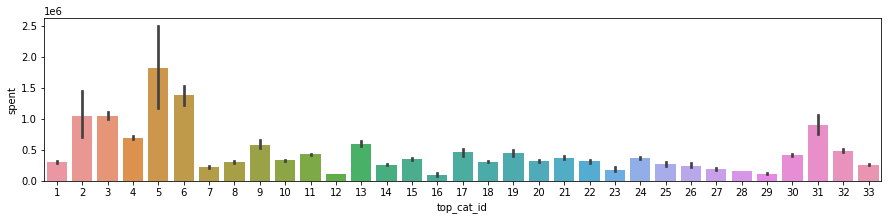

In [116]:
plt.figure(figsize=(15,3)) 
ax = sns.barplot(x="top_cat_id", y="spent", data=baskets)


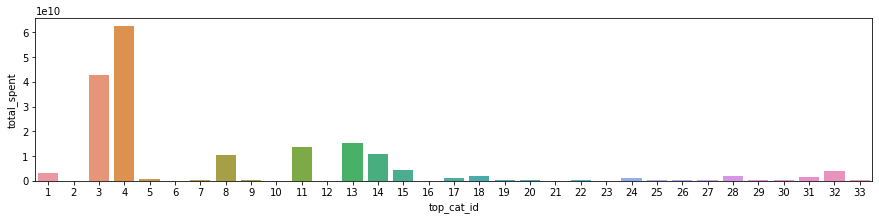

In [117]:
plt.figure(figsize=(15,3)) 
ax = sns.barplot(x="top_cat_id", y="total_spent", data=top_cats)

<AxesSubplot:xlabel='top_cat_id', ylabel='total_quantity'>

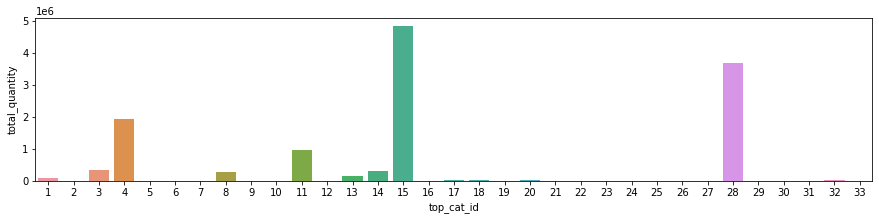

In [118]:
plt.figure(figsize=(15,3)) 
sns.barplot(x='top_cat_id',y='total_quantity',data=top_cats)

<AxesSubplot:xlabel='top_cat_id', ylabel='num_orders'>

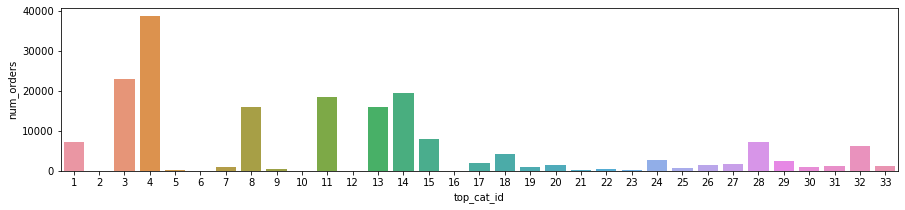

In [119]:
plt.figure(figsize=(15,3)) 
sns.barplot(x='top_cat_id',y='num_orders',data=top_cats)

<AxesSubplot:xlabel='top_cat_id', ylabel='avg_price'>

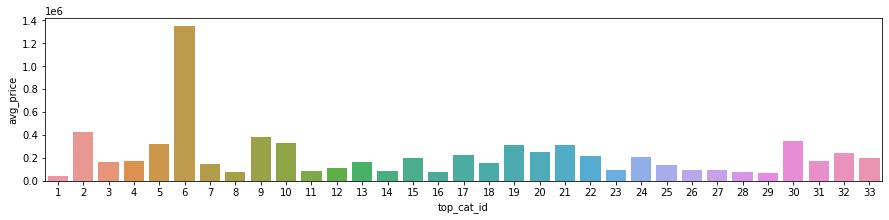

In [120]:
plt.figure(figsize=(15,3)) 
sns.barplot(x='top_cat_id',y='avg_price',data=top_cats)
#baskets.groupby(by="top_cat_id").mean().spent.plot()

<AxesSubplot:xlabel='top_cat_id'>

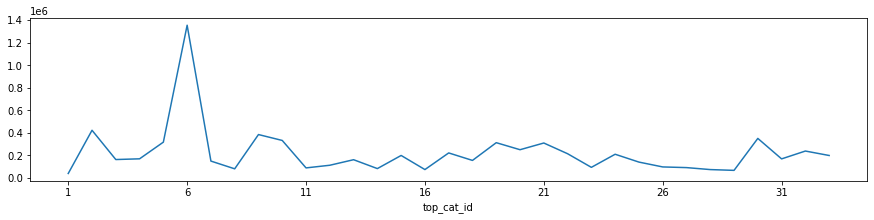

In [121]:
plt.figure(figsize=(15,3)) 
baskets.groupby(by="top_cat_id").mean().price.plot()

<AxesSubplot:xlabel='top_cat_id', ylabel='price'>

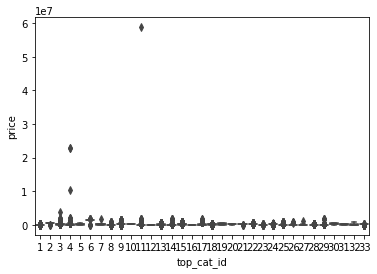

In [122]:
sns.boxplot(x='top_cat_id', y='price', data=baskets) 

<AxesSubplot:>

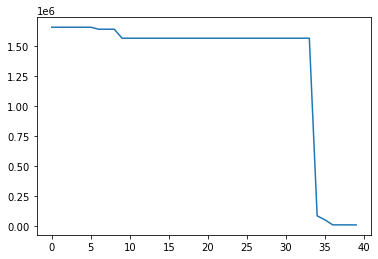

In [123]:
baskets[baskets['top_cat_id']==6].price.sort_values(ascending=False).reset_index(drop = True).plot()

In [124]:
print(1.2e+5)

120000.0


In [125]:
baskets.price.describe()

count    3.364610e+05
mean     1.378965e+05
std      1.744712e+05
min      4.375000e-02
25%      4.600000e+04
50%      1.070000e+05
75%      1.845000e+05
max      5.875000e+07
Name: price, dtype: float64

In [126]:
pd.options.display.max_rows = 100
from pprint import pprint
pprint(baskets.price.sort_values(ascending=False).reset_index(drop=True).head(100),compact=True)

0     58750000.0
1     23010000.0
2     23010000.0
3     10550000.0
4      3825000.0
5      2222000.0
6      2175000.0
7      2175000.0
8      2125000.0
9      1925000.0
10     1925000.0
11     1925000.0
12     1925000.0
13     1925000.0
14     1925000.0
15     1925000.0
16     1925000.0
17     1890000.0
18     1870000.0
19     1849000.0
20     1849000.0
21     1849000.0
22     1849000.0
23     1849000.0
24     1849000.0
25     1849000.0
26     1849000.0
27     1849000.0
28     1849000.0
29     1849000.0
30     1849000.0
31     1849000.0
32     1844000.0
33     1773000.0
34     1740000.0
35     1725000.0
36     1725000.0
37     1725000.0
38     1725000.0
39     1685000.0
40     1685000.0
41     1656500.0
42     1656500.0
43     1656500.0
44     1656500.0
45     1656500.0
46     1656500.0
47     1640000.0
48     1640000.0
49     1640000.0
50     1565000.0
51     1565000.0
52     1565000.0
53     1565000.0
54     1565000.0
55     1565000.0
56     1565000.0
57     1565000.0
58     1565000

In [127]:
pd.options.display.max_rows = 100
baskets.sort_values(by = ['price'], ascending=False).loc[:,['sku_id','price']].head(10)

,sku_id,price
78536,301,58750000.0
67262,200,23010000.0
66551,200,23010000.0
310185,432,10550000.0
5392,521,3825000.0
220150,438,2222000.0
277682,340,2175000.0
278592,340,2175000.0
2417,599,2125000.0
237889,974,1925000.0


<AxesSubplot:title={'center':'sku 340'}, xlabel='date'>

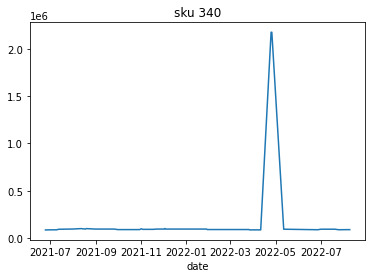

In [128]:
baskets[baskets.sku_id == 340].groupby('date').mean().price.plot(title="sku 340")

In [129]:
pd.options.display.max_rows = 100
baskets[baskets.sku_id == 340].sort_values(by='price',ascending= False).head(100)

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,date,year,month,day,hour,weekday,spent
278592,275340,47005,2022-04-26 13:52:47.626,1597,340,4,28,1,2175000.0,2022-04-26,2022,4,26,13,1,2175000.0
277682,277828,51100,2022-04-25 21:21:43.297,608,340,4,28,1,2175000.0,2022-04-25,2022,4,25,21,0,2175000.0
121064,121221,19000,2021-12-03 19:52:04.893,354,340,4,28,3,100000.0,2021-12-03,2021,12,3,19,4,300000.0
11350,11435,1006,2021-08-12 11:37:13.699,305,340,4,28,1,99000.0,2021-08-12,2021,8,12,11,3,99000.0
13163,13290,1211,2021-08-19 20:22:18.182,472,340,4,28,1,99000.0,2021-08-19,2021,8,19,20,3,99000.0
70311,70427,9093,2021-11-01 16:08:50.574,32,340,4,28,5,97000.0,2021-11-01,2021,11,1,16,0,485000.0
142767,142853,23378,2021-12-21 13:57:29.266,63,340,4,28,25,94000.0,2021-12-21,2021,12,21,13,1,2350000.0
113395,113637,17266,2021-11-29 14:58:14.928,559,340,4,28,25,94000.0,2021-11-29,2021,11,29,14,0,2350000.0
115434,115620,17825,2021-11-30 15:21:30.102,156,340,4,28,25,94000.0,2021-11-30,2021,11,30,15,1,2350000.0
118247,118408,18469,2021-12-02 12:39:15.964,754,340,4,28,25,94000.0,2021-12-02,2021,12,2,12,3,2350000.0


<AxesSubplot:title={'center':'top_cat_id 6'}, xlabel='date'>

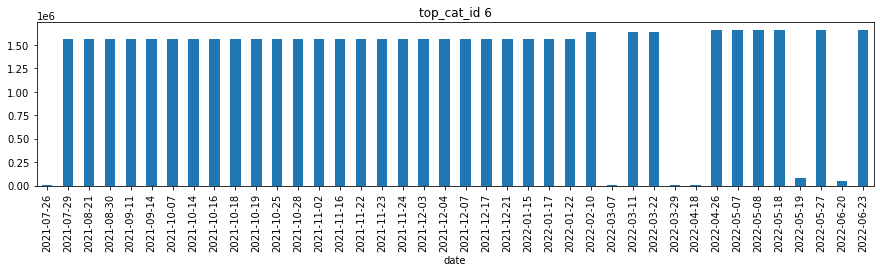

In [130]:
plt.figure(figsize=(15,3)) 
baskets[baskets.top_cat_id == 6].groupby('date').mean().price.plot(title="top_cat_id 6",kind='bar')

<AxesSubplot:title={'center':'top_cat_id 6'}, xlabel='date'>

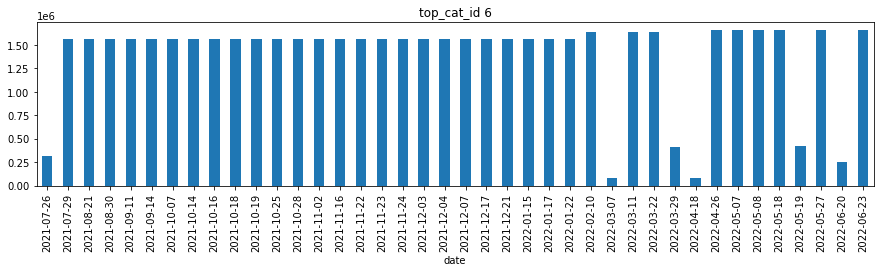

In [131]:
plt.figure(figsize=(15,3)) 
baskets[baskets.top_cat_id == 6].groupby('date').sum().spent.plot(title="top_cat_id 6",kind='bar')

In [132]:
baskets[baskets.top_cat_id == 6.0].sort_values(by="merchant_id")

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,date,year,month,day,hour,weekday,spent
259394,259603,47527,2022-03-29 09:26:08.555,33,822,6,33,50,8300.0,2022-03-29,2022,3,29,9,1,415000.0
7304,7367,621,2021-07-26 13:05:45.662,35,822,6,33,40,7950.0,2021-07-26,2021,7,26,13,0,318000.0
295747,295853,54049,2022-05-27 17:34:50.006,122,822,6,33,1,1656500.0,2022-05-27,2022,5,27,17,4,1656500.0
72515,72669,9649,2021-11-02 17:58:27.709,148,822,6,33,1,1565000.0,2021-11-02,2021,11,2,17,1,1565000.0
59434,59428,7554,2021-10-25 15:10:53.414,148,822,6,33,1,1565000.0,2021-10-25,2021,10,25,15,0,1565000.0
205859,206093,36999,2022-02-10 11:35:19.843,261,822,6,33,1,1640000.0,2022-02-10,2022,2,10,11,3,1640000.0
173336,173450,29993,2022-01-17 13:46:09.700,375,822,6,33,1,1565000.0,2022-01-17,2022,1,17,13,0,1565000.0
103623,103790,15474,2021-11-23 09:31:53.009,375,822,6,33,1,1565000.0,2021-11-23,2021,11,23,9,1,1565000.0
103027,103178,15370,2021-11-22 15:52:03.238,375,822,6,33,1,1565000.0,2021-11-22,2021,11,22,15,0,1565000.0
93710,93844,13293,2021-11-16 09:47:12.814,375,822,6,33,1,1565000.0,2021-11-16,2021,11,16,9,1,1565000.0


In [133]:
baskets10.sort_values(by = ['price'], ascending=True).loc[:,['sku_id','price']]

,sku_id,price
0,341,0.0
1093,679,0.0
1098,8,0.0
1101,166,0.0
1102,764,0.0
...,...,...
22218,1463,1925000.0
29189,1463,1925000.0
26620,1461,1925000.0
29188,1461,1925000.0


In [134]:
baskets250.price.sort_values(ascending=False).head(10)

2130      3825000.0
134738    2175000.0
763       2125000.0
164745    1925000.0
109325    1925000.0
142500    1925000.0
168446    1925000.0
142499    1925000.0
112471    1925000.0
164746    1925000.0
Name: price, dtype: float64

In [135]:
baskets.price.sort_values(ascending=False).head()

78536     58750000.0
67262     23010000.0
66551     23010000.0
310185    10550000.0
5392       3825000.0
Name: price, dtype: float64

In [136]:
baskets[baskets['price']==58750000.0]

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,date,year,month,day,hour,weekday,spent
78536,78641,10750,2021-11-06 09:53:53.181,1103,301,11,27,1,58750000.0,2021-11-06,2021,11,6,9,5,58750000.0


In [137]:
baskets10[baskets10['price']==2175000.0]

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,date,year,month,day,hour,weekday,spent
25568,285542,47838,2022-04-26 13:52:47.626,2173,774,4,31,1,2175000.0,2022-04-26,2022,4,26,13,1,2175000.0


In [138]:
baskets[baskets['sku_id'] == 301]

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,date,year,month,day,hour,weekday,spent
917,914,83,2021-06-17 10:27:52.447,302,301,11,27,50,23250.0,2021-06-17,2021,6,17,10,3,1162500.0
1451,1784,129,2021-06-24 12:43:03.065,22,301,11,27,50,22000.0,2021-06-24,2021,6,24,12,3,1100000.0
1515,1514,135,2021-06-24 23:31:59.247,114,301,11,27,10,22000.0,2021-06-24,2021,6,24,23,3,220000.0
1529,1528,136,2021-06-24 23:58:49.239,114,301,11,27,50,24500.0,2021-06-24,2021,6,24,23,3,1225000.0
1571,1570,137,2021-06-25 00:01:29.306,109,301,11,27,50,24500.0,2021-06-25,2021,6,25,0,4,1225000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335546,335629,61825,2022-08-13 23:23:58.111,665,301,11,27,10,25500.0,2022-08-13,2022,8,13,23,5,255000.0
336143,336225,62017,2022-08-15 14:37:01.641,146,301,11,27,50,25500.0,2022-08-15,2022,8,15,14,0,1275000.0
336211,336249,61920,2022-08-15 15:15:51.713,441,301,11,27,150,25500.0,2022-08-15,2022,8,15,15,0,3825000.0
336255,336310,61998,2022-08-15 16:51:02.716,1770,301,11,27,50,25500.0,2022-08-15,2022,8,15,16,0,1275000.0


In [139]:
baskets10[baskets10['sku_id'] == 340]

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,date,year,month,day,hour,weekday,spent


In [140]:
baskets.groupby(['sku_id']).count().order_id.sort_values(ascending=False).reset_index().head(100)

,sku_id,order_id
0,327,7500
1,522,6919
2,390,6409
3,438,5589
4,523,4804
5,263,4548
6,185,4463
7,521,4462
8,276,3718
9,184,3480


In [141]:
from pprint import pprint
pprint(list(skus[skus["sku_id"] == 438].date), compact = True)

[datetime.date(2021, 4, 9), datetime.date(2021, 4, 15),
 datetime.date(2021, 4, 16), datetime.date(2021, 4, 17),
 datetime.date(2021, 4, 19), datetime.date(2021, 4, 20),
 datetime.date(2021, 4, 22), datetime.date(2021, 4, 30),
 datetime.date(2021, 5, 3), datetime.date(2021, 5, 5),
 datetime.date(2021, 5, 6), datetime.date(2021, 5, 8),
 datetime.date(2021, 5, 9), datetime.date(2021, 5, 10),
 datetime.date(2021, 5, 11), datetime.date(2021, 5, 17),
 datetime.date(2021, 5, 18), datetime.date(2021, 5, 19),
 datetime.date(2021, 5, 20), datetime.date(2021, 5, 21),
 datetime.date(2021, 5, 22), datetime.date(2021, 5, 24),
 datetime.date(2021, 5, 26), datetime.date(2021, 5, 27),
 datetime.date(2021, 5, 31), datetime.date(2021, 6, 2),
 datetime.date(2021, 6, 3), datetime.date(2021, 6, 4),
 datetime.date(2021, 6, 7), datetime.date(2021, 6, 8),
 datetime.date(2021, 6, 9), datetime.date(2021, 6, 10),
 datetime.date(2021, 6, 11), datetime.date(2021, 6, 14),
 datetime.date(2021, 6, 15), datetime.date(

<AxesSubplot:xlabel='date'>

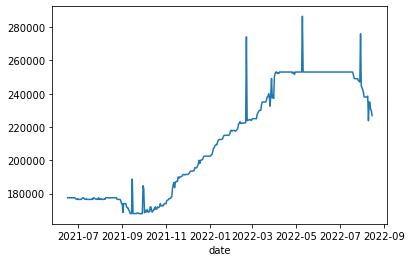

In [142]:
baskets[baskets.sku_id == 438].groupby('date').mean().price.plot()

<AxesSubplot:xlabel='date'>

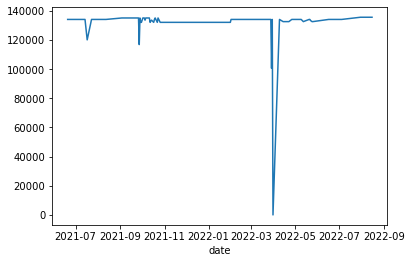

In [143]:
baskets[baskets.sku_id == 277].groupby('date').mean().price.plot()

<AxesSubplot:>

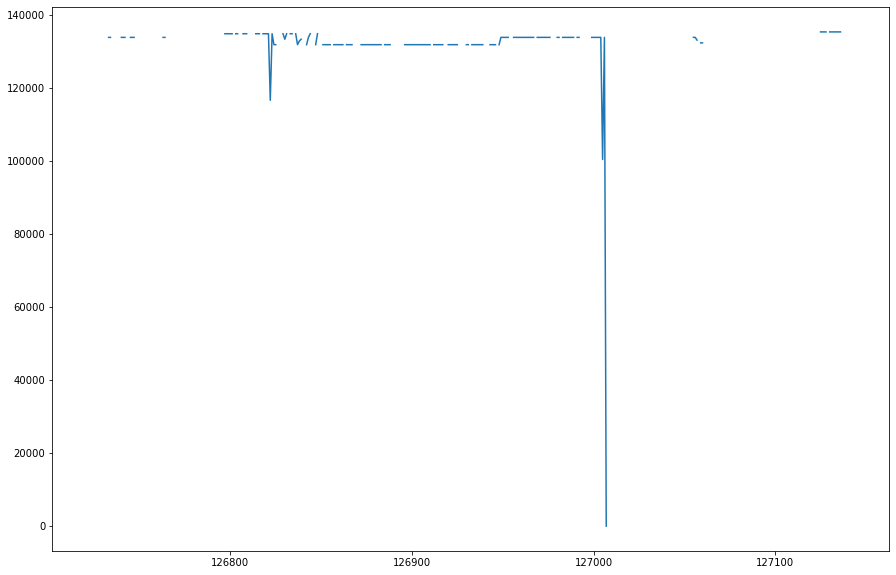

In [144]:
plt.figure(figsize=(15,10)) 
skus[skus["sku_id"] == 277].avg_price_by_day.plot()

<AxesSubplot:>

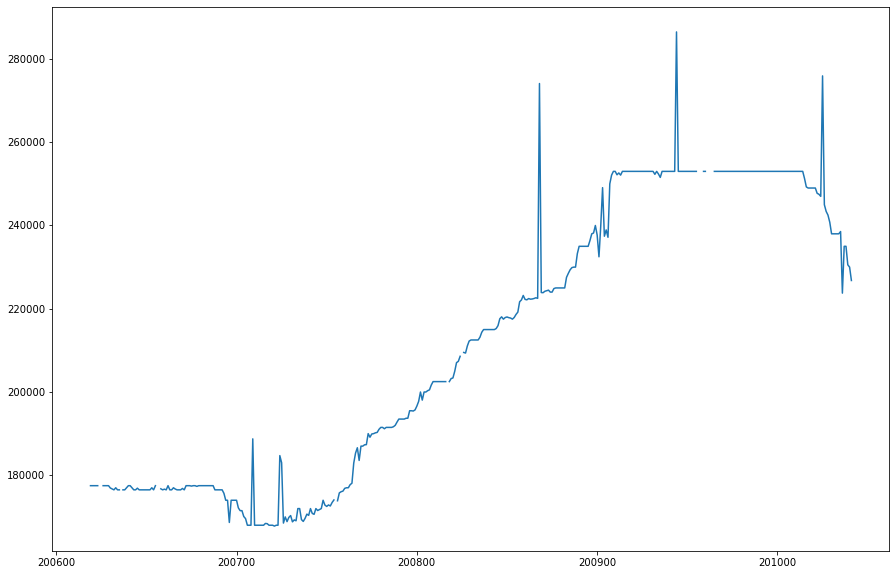

In [145]:
plt.figure(figsize=(15,10)) 
skus[skus["sku_id"] == 438].avg_price_by_day.plot()

In [146]:
skus10.groupby(['sku_id']).count().date.sort_values()

sku_id
10      396
325     396
322     396
32      396
316     396
       ... 
1559    396
1557    396
1553    396
1570    396
999     396
Name: date, Length: 1353, dtype: int64

<Figure size 1080x720 with 0 Axes>

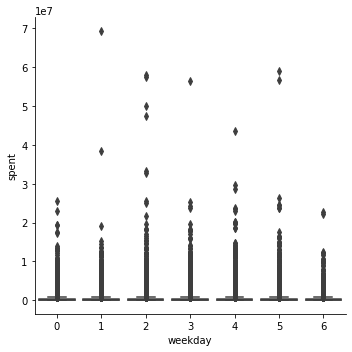

In [147]:
plt.figure(figsize=(15,10)) 
ax = sns.catplot(x="weekday", y = "spent",data=baskets250, palette="Set1",kind="box")

<Figure size 1080x2160 with 0 Axes>

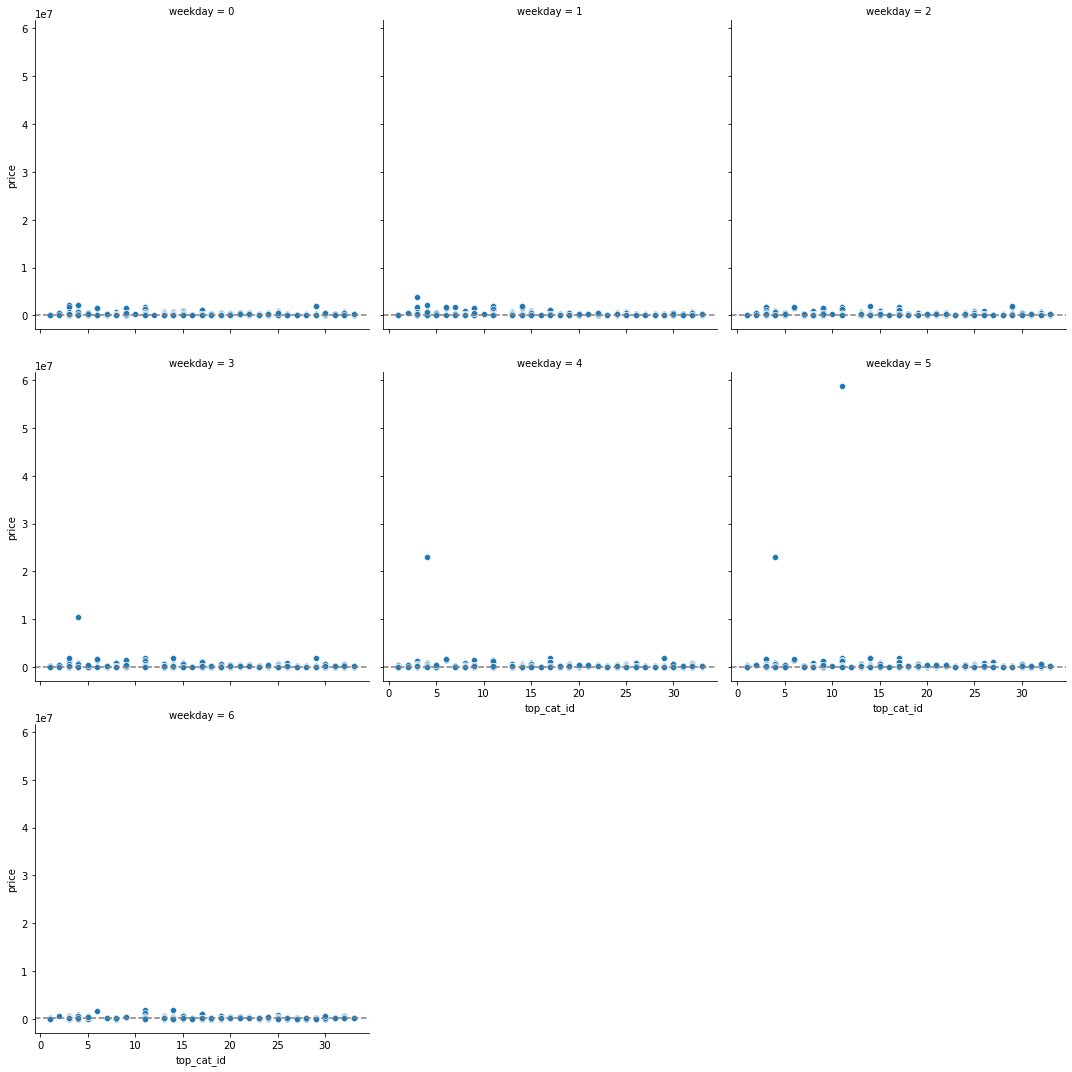

In [148]:
plt.figure(figsize=(15,30)) 
g = sns.FacetGrid(baskets, col="weekday", height=5, col_wrap=3)
g.map_dataframe(sns.scatterplot, x="top_cat_id",y="price")
g.refline(y=baskets["price"].median())

<Figure size 1080x2160 with 0 Axes>

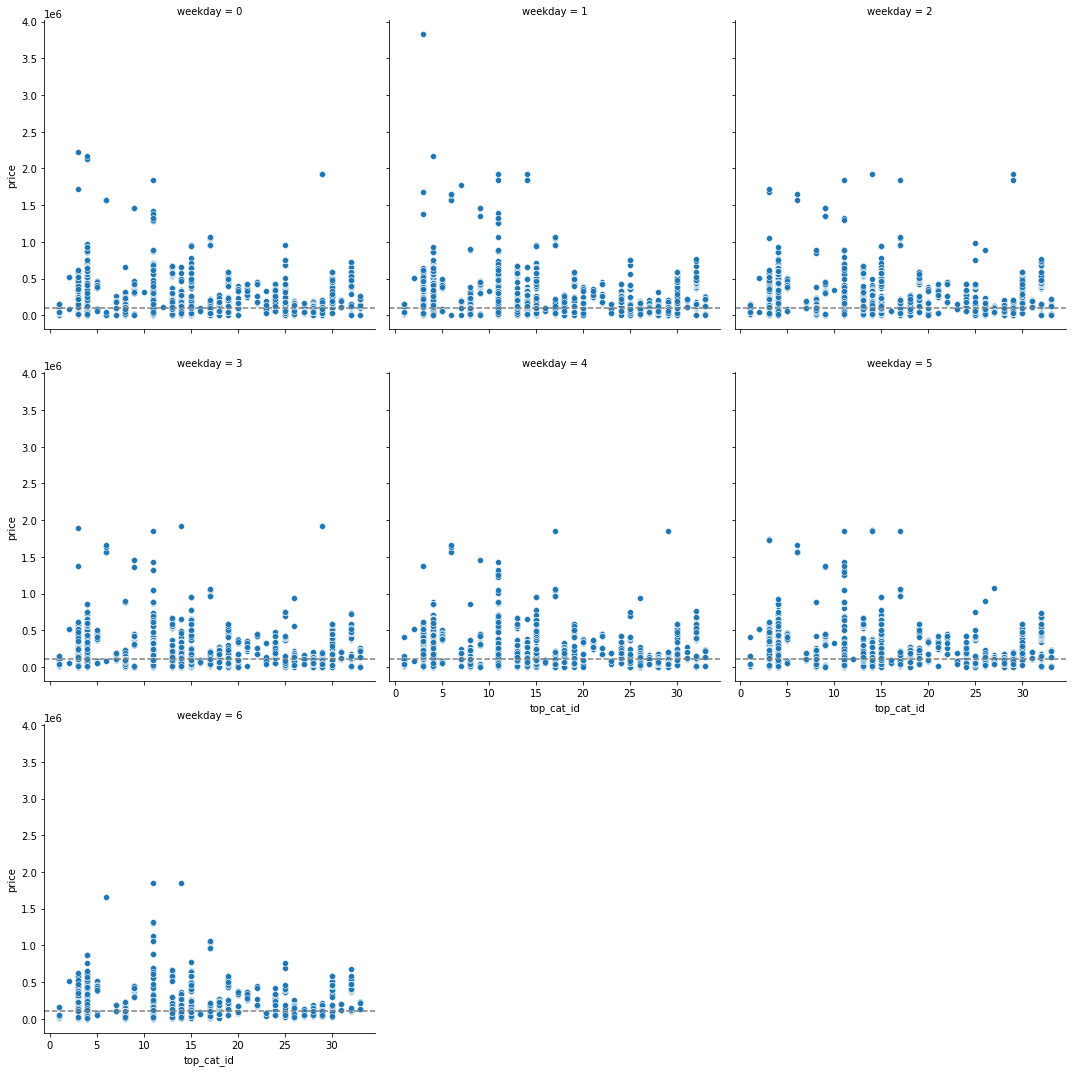

In [149]:
baskets1 = baskets.drop(baskets[baskets['price']> 10000000].index,axis=0)
plt.figure(figsize=(15,30)) 
g = sns.FacetGrid(baskets1, col="weekday", height=5, col_wrap=3)
g.map_dataframe(sns.scatterplot, x="top_cat_id",y="price")
g.refline(y=baskets1["price"].median())


<Figure size 1080x2160 with 0 Axes>

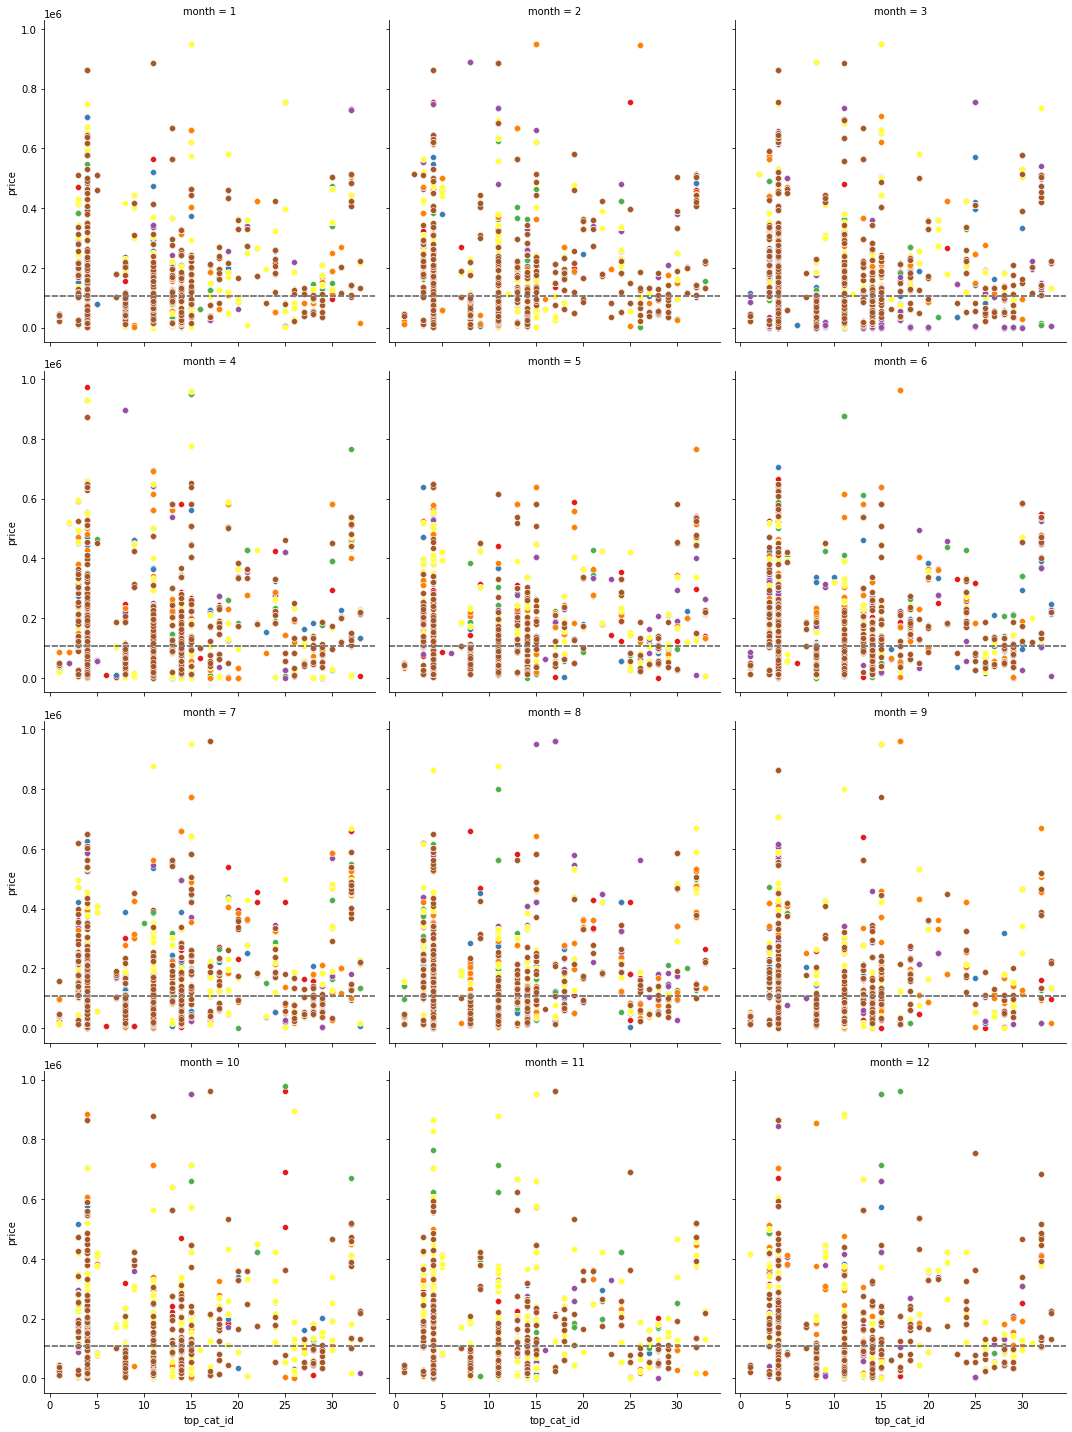

In [150]:
baskets1 = baskets.drop(baskets[baskets['price']> 1000000].index,axis=0)
plt.figure(figsize=(15,30)) 
g = sns.FacetGrid(baskets1, col="month", hue='weekday', palette="Set1", height=5, col_wrap=3)
g.map_dataframe(sns.scatterplot, x="top_cat_id",y="price")
g.refline(y=baskets1["price"].median())

<Figure size 1080x2160 with 0 Axes>

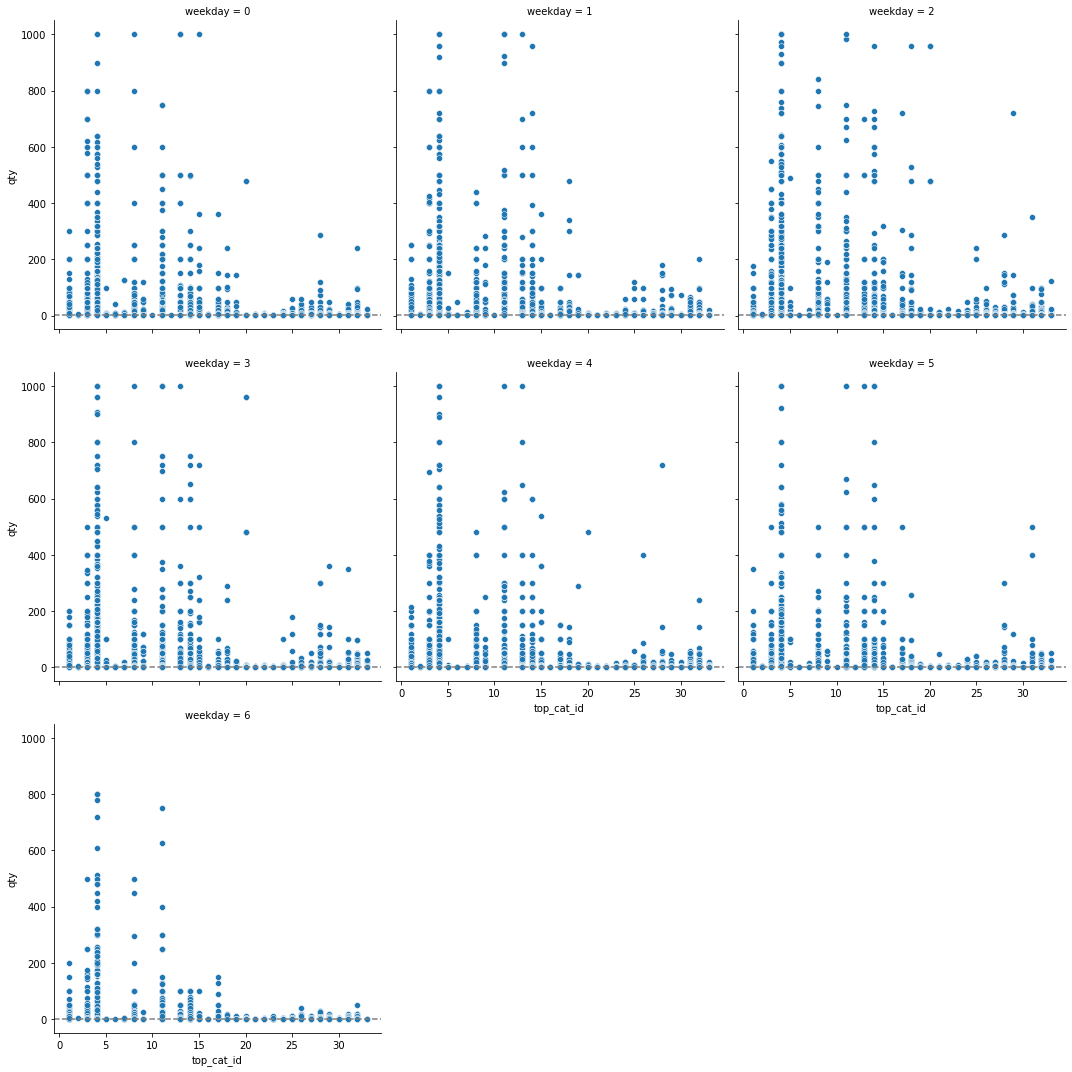

In [151]:
baskets1 = baskets.drop(baskets[baskets['qty']> 1000].index,axis=0)
plt.figure(figsize=(15,30)) 
g = sns.FacetGrid(baskets1, col="weekday", height=5, col_wrap=3)
g.map_dataframe(sns.scatterplot, x="top_cat_id",y="qty")
g.refline(y=baskets1["qty"].median())

/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

<AxesSubplot:xlabel='avg_spent_per_order', ylabel='Density'>

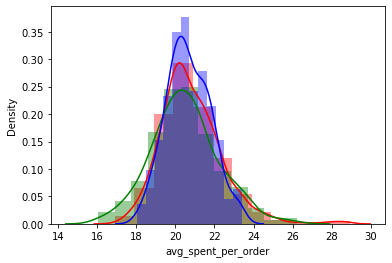

In [152]:
from turtle import color


sns.distplot(merchants.avg_spent_per_order.apply(lambda x: math.log(x,2)),bins=12,color='red')
sns.distplot(merchants10.avg_spent_per_order.apply(lambda x: math.log(x,2)),bins=12,color='green')
sns.distplot(merchants250.avg_spent_per_order.apply(lambda x: math.log(x,2)),bins=12,color='blue')


In [165]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score



def find_elbow(df, colnames, clusters_range):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    inertias = [] # wcss: Within Cluster Sum of Squares
    for k in clusters_range:
        kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
        inertias.append(kmeans.inertia_)
    plt.figure()
    plt.plot(clusters_range,inertias, marker='o')
    plt.title('Elbow method for deciding on k')
    plt.xlabel('Number of clusters: k')
    plt.ylabel('inertia')
    plt.show()
    return

def run_kmeans(df, colnames, k):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
    df['cluster'] = kmeans.labels_
    return df




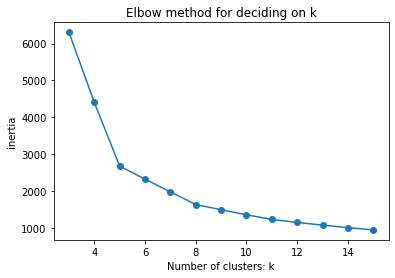

In [166]:
df = merchants
colnames = merchants.columns[2:]
clusters_range = [3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(df, colnames,clusters_range)

#kmeans.cluster_centers_

In [167]:
df = merchants
colnames = merchants.columns[2:]
k = 6
merchants_kmeans = run_kmeans(df, colnames,k)
merchants_kmeans.groupby("cluster").size()


cluster
0    584
1    725
2    205
3      1
4     14
5    609
dtype: int64

In [169]:
df = merchants
colnames = merchants.columns[2:]
k = 5
merchants_kmeans = run_kmeans(df, colnames,k)
merchants_kmeans.groupby("cluster").size()

cluster
0     377
1    1137
2     609
3      14
4       1
dtype: int64

In [170]:
df = merchants
colnames = merchants.columns[2:]
k = 5
merchants_kmeans = run_kmeans(df, colnames,k)
merchants_kmeans.groupby("cluster").size()

cluster
0     377
1     609
2    1137
3      14
4       1
dtype: int64

In [181]:
merchants_kmeans[merchants_kmeans["cluster"]==3]

,merchant_id,total_spent,num_orders,num_days,num_skus,num_top_cats,num_sub_cats,avg_spent_per_order,cluster
35,36,4.106996e+08,2,2,58,15,23,2.053498e+08,3
41,42,5.254210e+08,2,2,12,2,5,2.627105e+08,3
45,46,1.439045e+09,4,4,11,2,6,3.597612e+08,3
46,47,2.370813e+09,5,5,24,4,5,4.741626e+08,3
60,61,1.419515e+09,6,6,27,9,14,2.365858e+08,3
80,81,1.067530e+09,3,3,15,3,5,3.558432e+08,3
81,82,1.435016e+09,3,3,16,2,4,4.783388e+08,3
83,84,6.631100e+08,2,2,12,2,6,3.315550e+08,3
92,93,2.068602e+09,5,5,13,2,5,4.137203e+08,3
94,95,5.033360e+08,2,2,10,2,5,2.516680e+08,3


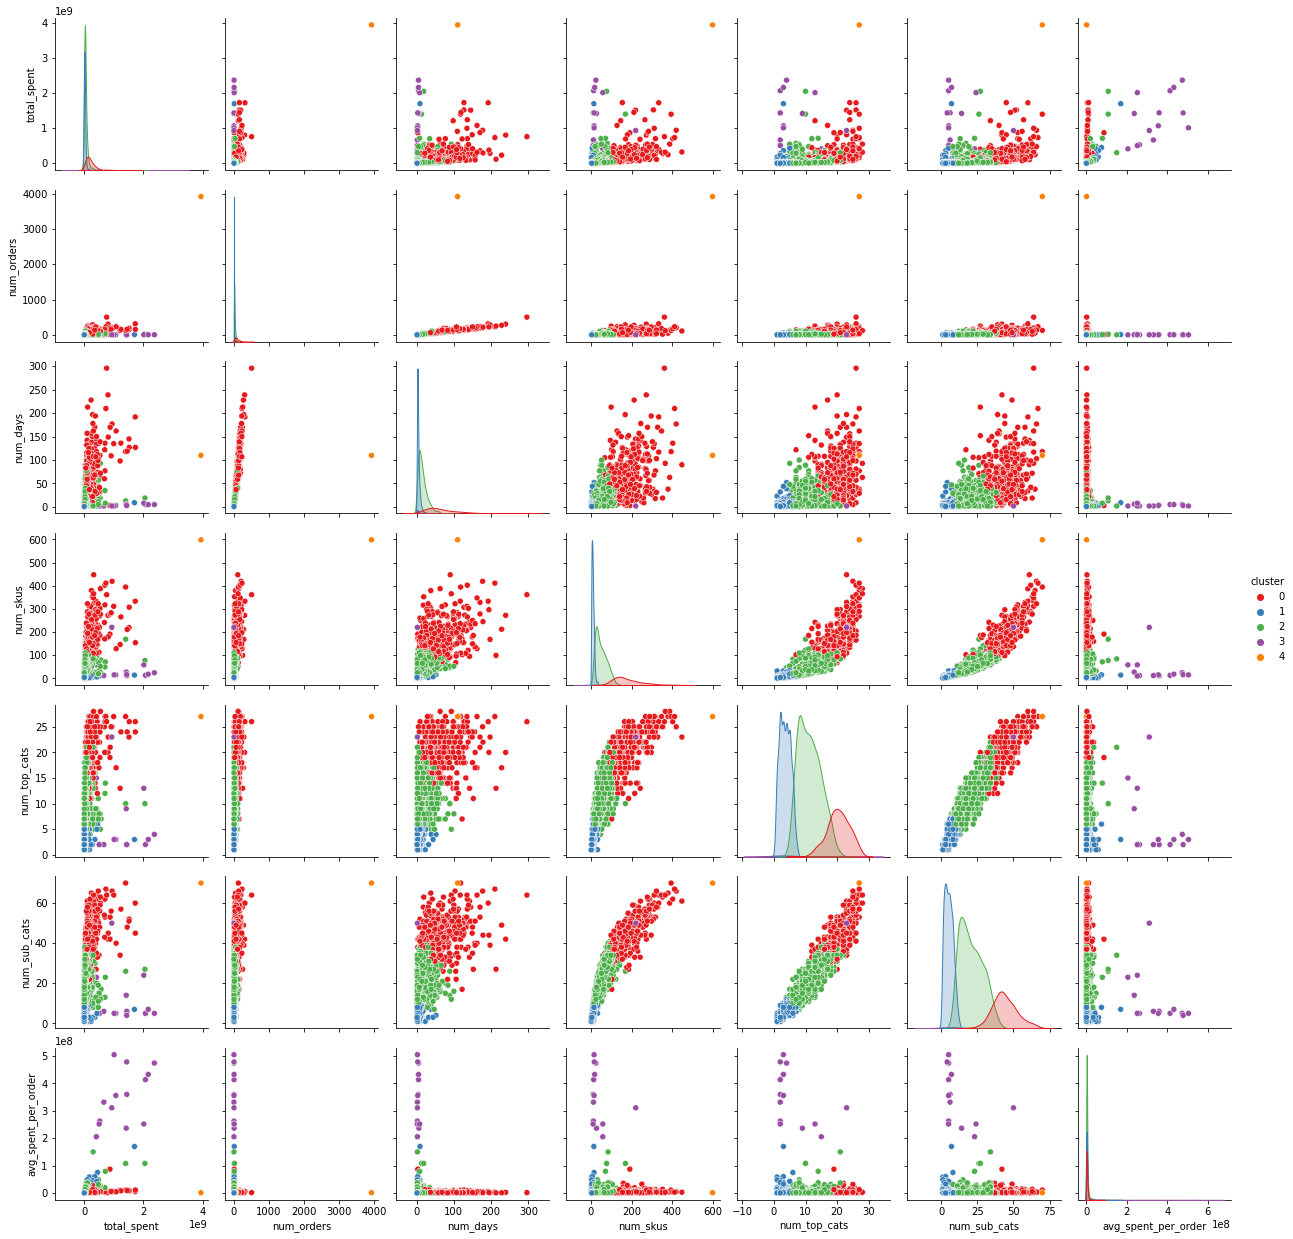

In [171]:
sns.pairplot(data=merchants_kmeans, hue="cluster", palette="Set1")


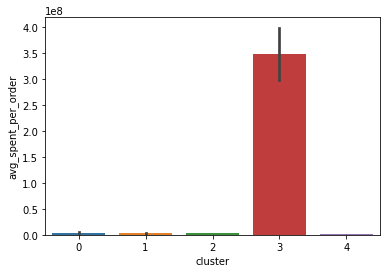

In [172]:
ax = sns.barplot(x="cluster", y="avg_spent_per_order", data=merchants_kmeans)

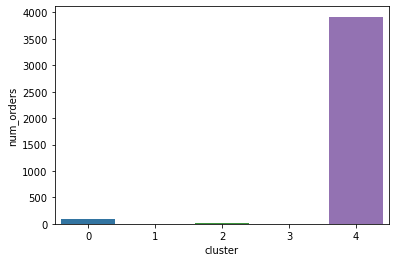

In [173]:
ax = sns.barplot(x="cluster", y="num_orders", data=merchants_kmeans)

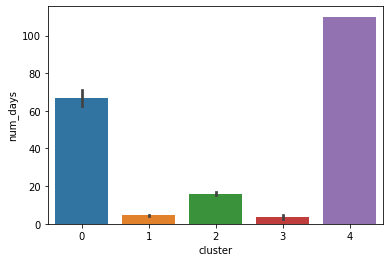

In [174]:
ax = sns.barplot(x="cluster", y="num_days", data=merchants_kmeans)

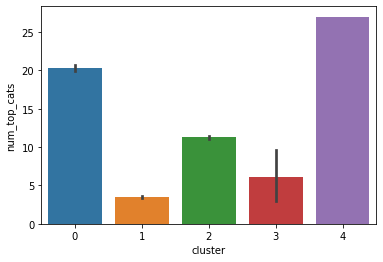

In [175]:
ax = sns.barplot(x="cluster", y="num_top_cats", data=merchants_kmeans)

In [176]:
merchants_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2138 entries, 0 to 2137
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   merchant_id          2138 non-null   category
 1   total_spent          2138 non-null   float64 
 2   num_orders           2138 non-null   int64   
 3   num_days             2138 non-null   int64   
 4   num_skus             2138 non-null   int64   
 5   num_top_cats         2138 non-null   int64   
 6   num_sub_cats         2138 non-null   int64   
 7   avg_spent_per_order  2138 non-null   float64 
 8   cluster              2138 non-null   int32   
dtypes: category(1), float64(2), int32(1), int64(5)
memory usage: 210.8 KB


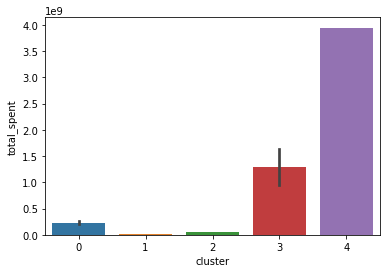

In [177]:
ax = sns.barplot(x="cluster", y="total_spent", data=merchants_kmeans)

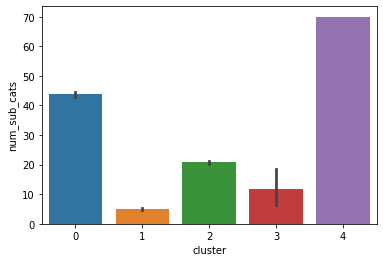

In [178]:
ax = sns.barplot(x="cluster", y="num_sub_cats", data=merchants_kmeans)

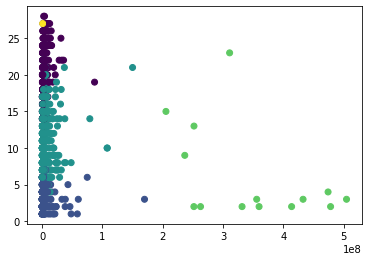

In [179]:

plt.scatter(merchants["avg_spent_per_order"], merchants["num_top_cats"],c=merchants.cluster)
plt.show()

In [180]:
#Counting the frequency
freq = baskets['merchant_id'].value_counts()
print(freq)

664     9498
337     2900
29      2839
290     2417
414     2289
        ... 
519        2
285        2
1914       2
1363       2
1852       2
Name: merchant_id, Length: 2138, dtype: int64


In [ ]:
frequency_df = baskets.groupby(
    by=['merchant_id'], as_index=False)['date'].count()
frequency_df.columns = ['merchant_id', 'Frequency']
frequency_df.head()

In [ ]:
merchants.avg_spent_per_order.sort_values(ascending=False).reset_index(drop=True).head(33)

In [ ]:
merchants.num_days.plot()

In [ ]:
merchants.total_spent.plot()

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(merchants_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
ax = sns.barplot(x="cluster", y="avg_spent_per_order", data=merchants_data)

### cluster 3 looks like containing merchants who have high average spending per orders.

In [ ]:
ax = sns.barplot(x="cluster", y="num_orders", data=merchants_data)

In [ ]:
plt.figure(figsize=(15,10)) 
ax = sns.catplot(x="num_days", y = "num_top_cats",data=merchants_data, hue="cluster", palette="Set1",ci="sd")

In [ ]:
plt.figure(figsize=(15,10)) 
ax = sns.catplot(x="num_days", y = "num_sub_cats",data=merchants_data, hue="cluster", palette="Set1",ci="sd")

In [ ]:
plt.figure(figsize=(15,10)) 
ax = sns.catplot(x="num_days", y = "num_orders",data=merchants_data, hue="cluster", palette="Set1",ci="sd")

In [ ]:
plt.figure(figsize=(15,10)) 
ax = sns.catplot(x="avg_spent_per_order", y = "num_days",data=merchants_data, hue="cluster", palette="Set1",ci="sd")

### cluster 4 consists of the merchants that have high number of days, 4 of them all above 100?
